In [1]:
from bertopic import BERTopic
import numpy as np
import pandas as pd
from transformers import pipeline
from bertopic.representation import TextGeneration
from bertopic.vectorizers import ClassTfidfTransformer
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load your dataset and Serafim embeddings
df = pd.read_pickle("../../data/adhd-beliefs-pt/adhd-beliefs-pt-embeddings-serafim.pkl")

In [3]:
def run_bertopic_model(df, text_column, embedding_column, min_topic_size=5):
    df = df.dropna(subset=text_column)
    texts = df[text_column].tolist()
    embeddings = np.vstack(df.loc[df[text_column].notna(), embedding_column])

    prompt = """
    Tens acesso ao seguinte conjunto de documentos de participantes:

    [DOCUMENTS]

    Estas respostas partilham um tema comum, que pode ser descrito pelas seguintes palavras-chave:

    [KEYWORDS]

    Com base nesta informação, gera um título curto e representativo para este tema.

    O título deve:
    - Ser claro, direto e conciso (máximo 4 palavras)
    - Refletir com precisão o conteúdo dos documentos
    - Estar escrito em português europeu

    Importante: devolve apenas o título e nada mais.
    Não incluas explicações, descrições ou frases completas.
    Se não conseguires identificar um tema claro, responde apenas com: Tema desconhecido
    """

    generator = pipeline("text-generation", model="meta-llama/Llama-3.2-3B-Instruct")
    representation_model = TextGeneration(generator, prompt=prompt)
    ctfidf_model = ClassTfidfTransformer(bm25_weighting=True, reduce_frequent_words=True)

    topic_model = BERTopic(
        representation_model=representation_model,
        language="multilingual",
        min_topic_size=min_topic_size,
        verbose=True,
        calculate_probabilities=True,
        ctfidf_model=ctfidf_model,
    )

    topics, probs = topic_model.fit_transform(texts, embeddings)
    df["topic"] = topics
    return df, topic_model, topics, probs

In [4]:
def topic_distribution_group(df):
    # Example: Count topics per group
    df["adhd_group"] = df["adhd_diagnosis"].apply(lambda x: "ADHD" if x == "Sim, diagnosticado" else "Non-ADHD")

    topic_counts = df.groupby(["topic", "adhd_group"]).size().unstack(fill_value=0)
    topic_counts["total"] = topic_counts.sum(axis=1)
    topic_counts = topic_counts.sort_values("total", ascending=False).drop(-1, errors="ignore")  # drop outliers

    topic_counts[["ADHD", "Non-ADHD"]].head(10).plot(kind="bar", stacked=True, figsize=(10, 5))
    plt.title("Top Topic Distribution by Group")
    plt.ylabel("Number of Documents")
    plt.xlabel("Topic ID")
    plt.tight_layout()
    plt.show()

In [5]:
def get_topics(df, topic_model, column):
    # Loop through each topic (excluding outliers)
    for topic in sorted(df["topic"].unique()):
        if topic == -1:
            continue

        topic_label = topic_model.get_topic_info().set_index("Topic").loc[topic]["Name"]
        texts_in_topic = df[df["topic"] == topic][column]

        print(f"\n\n🧠 Topic {topic}: {topic_label}")
        print(f"Total documents: {len(texts_in_topic)}")
        print("-" * 60)

        for idx, text in enumerate(texts_in_topic, 1):
            print(f"{idx}. {text}\n")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cpu
2025-08-03 02:46:27,586 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-03 02:46:35,509 - BERTopic - Dimensionality - Completed ✓
2025-08-03 02:46:35,513 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-03 02:46:35,525 - BERTopic - Cluster - Completed ✓
2025-08-03 02:46:35,528 - BERTopic - Representation - Fine-tuning topics using representation models.
100%|██████████| 24/24 [28:20<00:00, 70.83s/it]
2025-08-03 03:14:55,624 - BERTopic - Representation - Completed ✓


Valid topic documents: 127 of 148


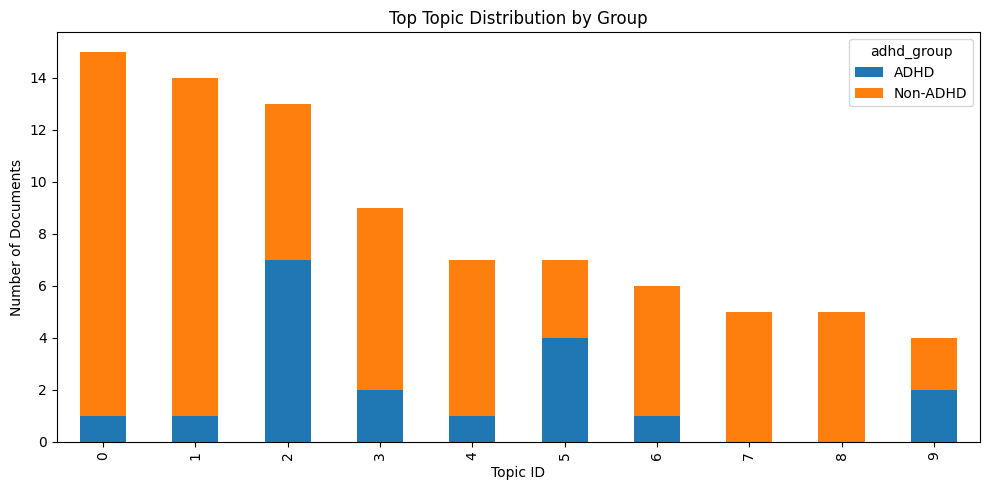



🧠 Topic 0: 0_ O título gerado é: Jogos e Programação
     Tema desconhecido___
Total documents: 15
------------------------------------------------------------
1. Jogos no geral, adoro aprender e perceber mecânicas diferentes. Minmaxing um jogo é sempre um desafio interessante, seja um videojogo complexo um um jogo de tabuleiro para crianças 

2. Video jogos, independentemente do género, gosto do sentimento de grind-achievement que eles proporcionam.

3. Desde que cresci sempre me fiquei a olhar para computadores e o potencial imenso que ele têm, cresci no mundo dos video-jogos e nunca olhei para trás a pensar que isto não é algo 
extraordinário e até hoje continuo a adorar o potencial de conseguir fazer seja o que for que a minha criatividade me puxa para fazer

4. Gosto bastante da área de inteligência artificial porque acredito que pode melhorar a vida de muita gente. Sempre foi algo que quis saber mais mas mesmo hoje em dia sinto que sei 1% das coisas que daria então é aprender t

In [6]:
column = "special_interest"
df, topic_model, topics, probs = run_bertopic_model(df, column, f"{column}_embedding", min_topic_size=2)
valid_docs = df[df["topic"] != -1]
print("Valid topic documents:", len(valid_docs), "of", len(df))
topic_distribution_group(df)
get_topics(df, topic_model, column)

In [ ]:
mask_women_adhd = (df['sex']=="Feminino") & (df['adhd_diagnosis']=="Sim, diagnosticado")
df_women_adhd = df[mask_women_adhd]

column = "special_interest"
df_women_adhd, topic_model, topics, probs = run_bertopic_model(df_women_adhd, column, f"{column}_embedding", min_topic_size=2)
valid_docs = df_women_adhd[df_women_adhd["topic"] != -1]
print("Valid topic documents:", len(valid_docs), "of", len(df_women_adhd))
get_topics(df_women_adhd, topic_model, column)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cpu
2025-08-03 03:14:57,029 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-03 03:14:57,849 - BERTopic - Dimensionality - Completed ✓
2025-08-03 03:14:57,850 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-03 03:14:57,862 - BERTopic - Cluster - Completed ✓
2025-08-03 03:14:57,864 - BERTopic - Representation - Fine-tuning topics using representation models.
100%|██████████| 6/6 [05:30<00:00, 55.06s/it]
2025-08-03 03:20:28,244 - BERTopic - Representation - Completed ✓


Valid topic documents: 20 of 21


KeyError: "['Non-ADHD'] not in index"

In [ ]:
mask_others = ~mask_women_adhd
df_others = df[mask_others]

column = "special_interest"
df_others, topic_model, topics, probs = run_bertopic_model(df_others, column, f"{column}_embedding", min_topic_size=2)
valid_docs = df_others[df_others["topic"] != -1]
print("Valid topic documents:", len(valid_docs), "of", len(df_others))
get_topics(df_others, topic_model, column)